# Ton Charts

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/VoyagesAPI/TonChatrts.ipynb).

In this example we are going to calculate the following metrics over time:
* **Ton Days**: Deadweight of the vessel times the number of days the vessels was laden during a voyage.  
* **Ton Miles**: Deadweight of the vessel times laden distance in miles during a voyage.  

**Ton Days time series calculation:**  
The goal is to distribute the ton days of a vessel across the days of the laden leg of the voyage. For this reason we calculate ton days per day, which is ton days divided by the number of laden days.

**Ton Miles time series calculation:**   
The goal is to distribute the ton miles of a vessel across the seagoing days of the laden leg of the voyage. For this reason we need to calculate ton miles per day between two voyage events (load events, stops) during the laden leg of the voyage.  

## Setup
- Install the Signal Ocean SDK:

In [1]:
%%capture
!pip install signal-ocean

- Get your personal Signal Ocean API subscription key (acquired [here](https://apis.signalocean.com/profile)) and replace it below:

In [2]:
signal_ocean_api_key = ""  # replace with your subscription key

from signal_ocean import Connection
connection = Connection(signal_ocean_api_key)

## Import all required modules

In [3]:
from signal_ocean import Connection
from signal_ocean.voyages import VoyagesAPI
from signal_ocean.vessels import VesselsAPI

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)


from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt

# Create instances of APIs used throughout this notebook:
connection = Connection(signal_ocean_api_key)
voyages_api = VoyagesAPI(connection)
vessels_api = VesselsAPI(connection)

## Get the relevant Data (Voyages Data API)

- Define the Voyages Data parameters

In [53]:
# Vessel Class
vessel_class_id = 70

# Areas of interest
load_areas = ['Caribs', 'US Atlantic Coast', 'Brazil',
              'East Coast Central America', 'US Gulf', 'East Coast Mexico']

dis_areas = ['East Coast India', 'Pakistan / West Coast India', 'East Africa']


# Start date for Ton Miles & Ton Days Calculation (Last 6 months)
tonncharts_start_date = date.today() - relativedelta(months=6)

Voyages Data API allows users to retrieve voyages based on voyage start date.
Since we need all the port calls of the last six months to calculate ton days and ton miles, we will have to retrieve voyages that ended after tonncharts_start_date.

In [6]:
voyages_start_date = tonncharts_start_date - relativedelta(months=6)

voyages_flat = voyages_api.get_voyages_flat(
    vessel_class_id=vessel_class_id, date_from=voyages_start_date
)

In [7]:
voyages_df = pd.DataFrame(v.__dict__ for v in voyages_flat.voyages)
events_df = pd.DataFrame(v.__dict__ for v in voyages_flat.events)
events_details_df = pd.DataFrame(v.__dict__ for v in voyages_flat.event_details)
geos_df = pd.DataFrame(v.__dict__ for v in voyages_flat.geos).drop_duplicates()

In [8]:
# we will use only voyages that have ended after the tonncharts_start_date
voyages_df.end_date = pd.to_datetime(voyages_df.end_date, errors = 'coerce', utc = True)
voyages_df = voyages_df[voyages_df.end_date.dt.date >= tonncharts_start_date]

## Get the relevant Data (Vessels API)

In [9]:
capesize_vessels = vessels_api.get_vessels_by_vessel_class(70)

In [10]:
capesize_vessels_df = pd.DataFrame(v.__dict__ for v in capesize_vessels)

We need to merge the load events with the events details because we need to retrieve the start time of operation for each load port call.

In [40]:
load_events_with_start_time_of_operation = (
    events_df[events_df.purpose == 'Load']
    .merge(
        events_details_df.loc[
            (events_details_df.event_detail_type.isin(['Jetty','StS','Stop'])),
            ['event_id','start_time_of_operation']],
        how = 'left',
        left_on = 'id',
        right_on = 'event_id'
    )
    .groupby('event_id')
    .head(1)
)

In [58]:
toncharts_df = (
    pd.concat(
        [load_events_with_start_time_of_operation,
         events_df[~events_df.purpose.isin(['Load','Start'])]],
        ignore_index = True
    )
    .merge(
        voyages_df[
            ['id','imo','voyage_number','first_load_arrival_date',
             'end_date','laycan_from',
            'laden_distance','predicted_laden_distance']
        ],
        how = 'left',
        left_on = 'voyage_id',
        right_on = 'id',
        suffixes = ['_ev','_voy']
    ).merge(
        capesize_vessels_df[['imo','deadweight']],
        how = 'inner',
        on = 'imo'
    ).merge(
        geos_df,
        how = 'inner',
        left_on = 'geo_asset_id',
        right_on = 'id',
        suffixes = ['_vs','_geos']
    )
)

In [59]:
# get only port calls after the first load
toncharts_df = toncharts_df.loc[toncharts_df['arrival_date'] >= toncharts_df['first_load_arrival_date']]

In [60]:
toncharts_df['first_load_arrival_area'] = (
    toncharts_df
    .sort_values('arrival_date')
    .groupby('voyage_id')
    .area_name_level0_geos
    .transform('first')
)

toncharts_df['last_discharge_arrival_area'] = (
    toncharts_df
    .sort_values('arrival_date')
    .groupby('voyage_id')
    .area_name_level0_geos
    .transform('last')
)

In [63]:
#filter on the load/discharge areas
load_area_filter = (toncharts_df.first_load_arrival_area.isin(load_areas))
discharge_area_filter = (toncharts_df.last_discharge_arrival_area.isin(dis_areas))

toncharts_df = toncharts_df[load_area_filter & discharge_area_filter]

Here we introduce start_date as the first day of the laden leg for each voyage. Start date for a voyage is:  
* start_time_of_operation if exists, else
* laycan_from if exists, else
* sailing_date of the first load port call minus 2 days

In [65]:
condlist = [
    toncharts_df.start_time_of_operation.notna(),
    toncharts_df.laycan_from.notna()
]

choicelist = [toncharts_df.start_time_of_operation, toncharts_df.laycan_from]

toncharts_df['start_date'] = np.select(
    condlist, 
    choicelist, 
    default= (toncharts_df.sailing_date - timedelta(days=2))
)

In [66]:
# voyage days calculation
toncharts_df['voyage_days'] = (
    toncharts_df['end_date'] - toncharts_df['start_date']
) / np.timedelta64(1, 'D')

toncharts_df['voyage_days'] = (
    toncharts_df
    .sort_values('arrival_date')
    .groupby('voyage_id')
    .voyage_days
    .transform('first')
)

toncharts_df = toncharts_df[toncharts_df['voyage_days'] <= 250]

In [67]:
# ton days calculation
toncharts_df['ton_days'] = toncharts_df.deadweight * toncharts_df.voyage_days
toncharts_df['ton_days_per_day'] = toncharts_df.ton_days / toncharts_df.voyage_days

In [68]:
# voyage miles calculation
toncharts_df['voyage_miles'] = (
    toncharts_df['laden_distance'].fillna(0) + 
    toncharts_df['predicted_laden_distance'].fillna(0)
)

In [69]:
# calculation of the date ranges in which ton days and ton miles will be distributed
toncharts_df['next_arrival_date'] = (
    toncharts_df
    .sort_values('arrival_date')
    .groupby('voyage_id')['arrival_date']
    .shift(-1)
)

toncharts_df['tonmiles_daterange'] = (
    toncharts_df
    .apply(lambda row: pd.date_range(
        row.sailing_date.date() + timedelta(days = 1), 
        row.next_arrival_date.date() - timedelta(days = 1)) if not pd.isnull(row.next_arrival_date) else [], 
    axis = 1)
)

toncharts_df['tondays_daterange'] = (
    toncharts_df
    .apply(lambda row: pd.date_range(
        row.start_date.date(), 
        row.end_date.date()), 
    axis = 1)
)

In [70]:
#calculating seagoing days between events and total seagoing days of a voyage
toncharts_df['seagoing_hours_between_events'] = (
    toncharts_df['next_arrival_date'] - toncharts_df['sailing_date']
) /np.timedelta64(1,'h')

toncharts_df.loc[
    toncharts_df['seagoing_hours_between_events'] < 1.0, 
    'seagoing_hours_between_events'] = 1.0

toncharts_df['seagoing_days_between_events'] = toncharts_df['seagoing_hours_between_events']/24

toncharts_df['seagoing_days'] = (
    toncharts_df
    .groupby('voyage_id')
    .seagoing_days_between_events
    .transform('sum')
)

In [71]:
# calculating ton miles between events and total ton miles of a voyage
toncharts_df['ton_miles'] = toncharts_df['deadweight']*toncharts_df['voyage_miles']

toncharts_df['miles_between_events'] = (
    toncharts_df['voyage_miles']*
    toncharts_df['seagoing_days_between_events']/
    toncharts_df['seagoing_days']
)
toncharts_df['ton_miles_between_events_per_day'] = (
    toncharts_df['deadweight']*
    toncharts_df['miles_between_events']/
    toncharts_df['seagoing_days_between_events']
)

In [72]:
# calculating ton miles and ton days time series
ton_miles_ts = (
    toncharts_df.loc[
        (load_area_filter & discharge_area_filter) &
        (toncharts_df.purpose != 'Discharge'),
        ['voyage_id','tonmiles_daterange',
         'ton_miles_between_events_per_day']
    ].dropna()
    .explode('tonmiles_daterange')
    .rename(
        columns={
            'tonmiles_daterange':'date',
            'ton_miles_between_events_per_day':'ton_miles'
        })
    .drop_duplicates(subset = ['voyage_id','date'])
    .groupby('date')
    .sum()
    .rolling(window=7)
    .mean()
)

ton_days_ts = (
    toncharts_df.loc[
        (load_area_filter & discharge_area_filter),
        ['voyage_id','tondays_daterange',
         'ton_days_per_day']
    ]
    .explode('tondays_daterange')
    .rename(
        columns={
            'tondays_daterange':'date',
            'ton_days_per_day':'ton_days'
        })
    .drop_duplicates(subset = ['voyage_id','date'])
    .groupby('date')
    .sum()
    .rolling(window=7)
    .mean()
)

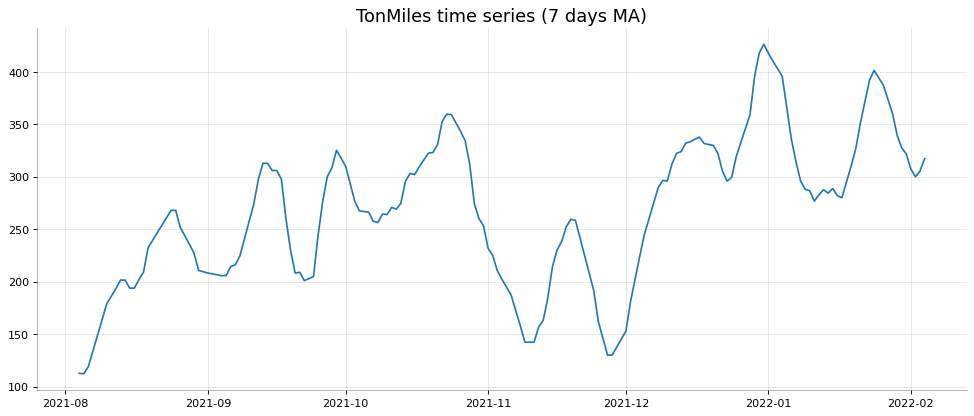

In [73]:
tm = ton_miles_ts.loc[tonncharts_start_date:date.today()]/1000000

plt.figure(figsize=(15,6), dpi= 80)
plt.plot(tm.index, tm.ton_miles)


plt.title("TonMiles time series (7 days MA)", fontsize=16)
plt.grid(axis='both', alpha=.3)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.show()

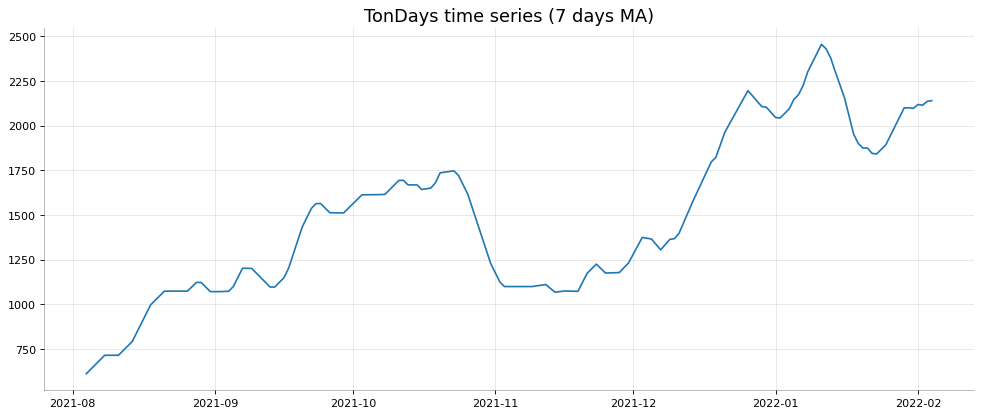

In [74]:
td = ton_days_ts.loc[tonncharts_start_date:date.today()]/1000

plt.figure(figsize=(15,6), dpi= 80)
plt.plot(td.index, td.ton_days)


plt.title("TonDays time series (7 days MA)", fontsize=16)
plt.grid(axis='both', alpha=.3)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.show()